Generating synthetic classification data...
Data splits - Train: 600, Val: 200, Test: 200

Training Standard SGD...
Epoch 0: Loss 12.9935, Val Acc 0.6550, Forgetting 0
Epoch 20: Loss 5.2093, Val Acc 0.8150, Forgetting 0
Epoch 40: Loss 3.0782, Val Acc 0.8300, Forgetting 0
Epoch 60: Loss 2.2177, Val Acc 0.8400, Forgetting 0
Epoch 80: Loss 1.6350, Val Acc 0.8250, Forgetting 3

Training with Forgetting Penalty (weight=0.5)...
Epoch 0: Loss 13.1320, Val Acc 0.5600, Forgetting 0, Penalty 0.0000
Epoch 20: Loss 5.1685, Val Acc 0.8450, Forgetting 2, Penalty 18.5000
Epoch 40: Loss 3.3441, Val Acc 0.8300, Forgetting 3, Penalty 25.0000
Epoch 60: Loss 2.3686, Val Acc 0.8450, Forgetting 0, Penalty 9.0000
Epoch 80: Loss 1.5305, Val Acc 0.8400, Forgetting 3, Penalty 18.0000

EXPERIMENT SUMMARY

FINAL PERFORMANCE:
Standard SGD     - Test Accuracy: 0.8550
Forgetting Penalty - Test Accuracy: 0.8450
Improvement: -0.0100 (-1.2%)

FORGETTING ANALYSIS:
Total forgetting (Standard): 214
Total forgetting (Penal

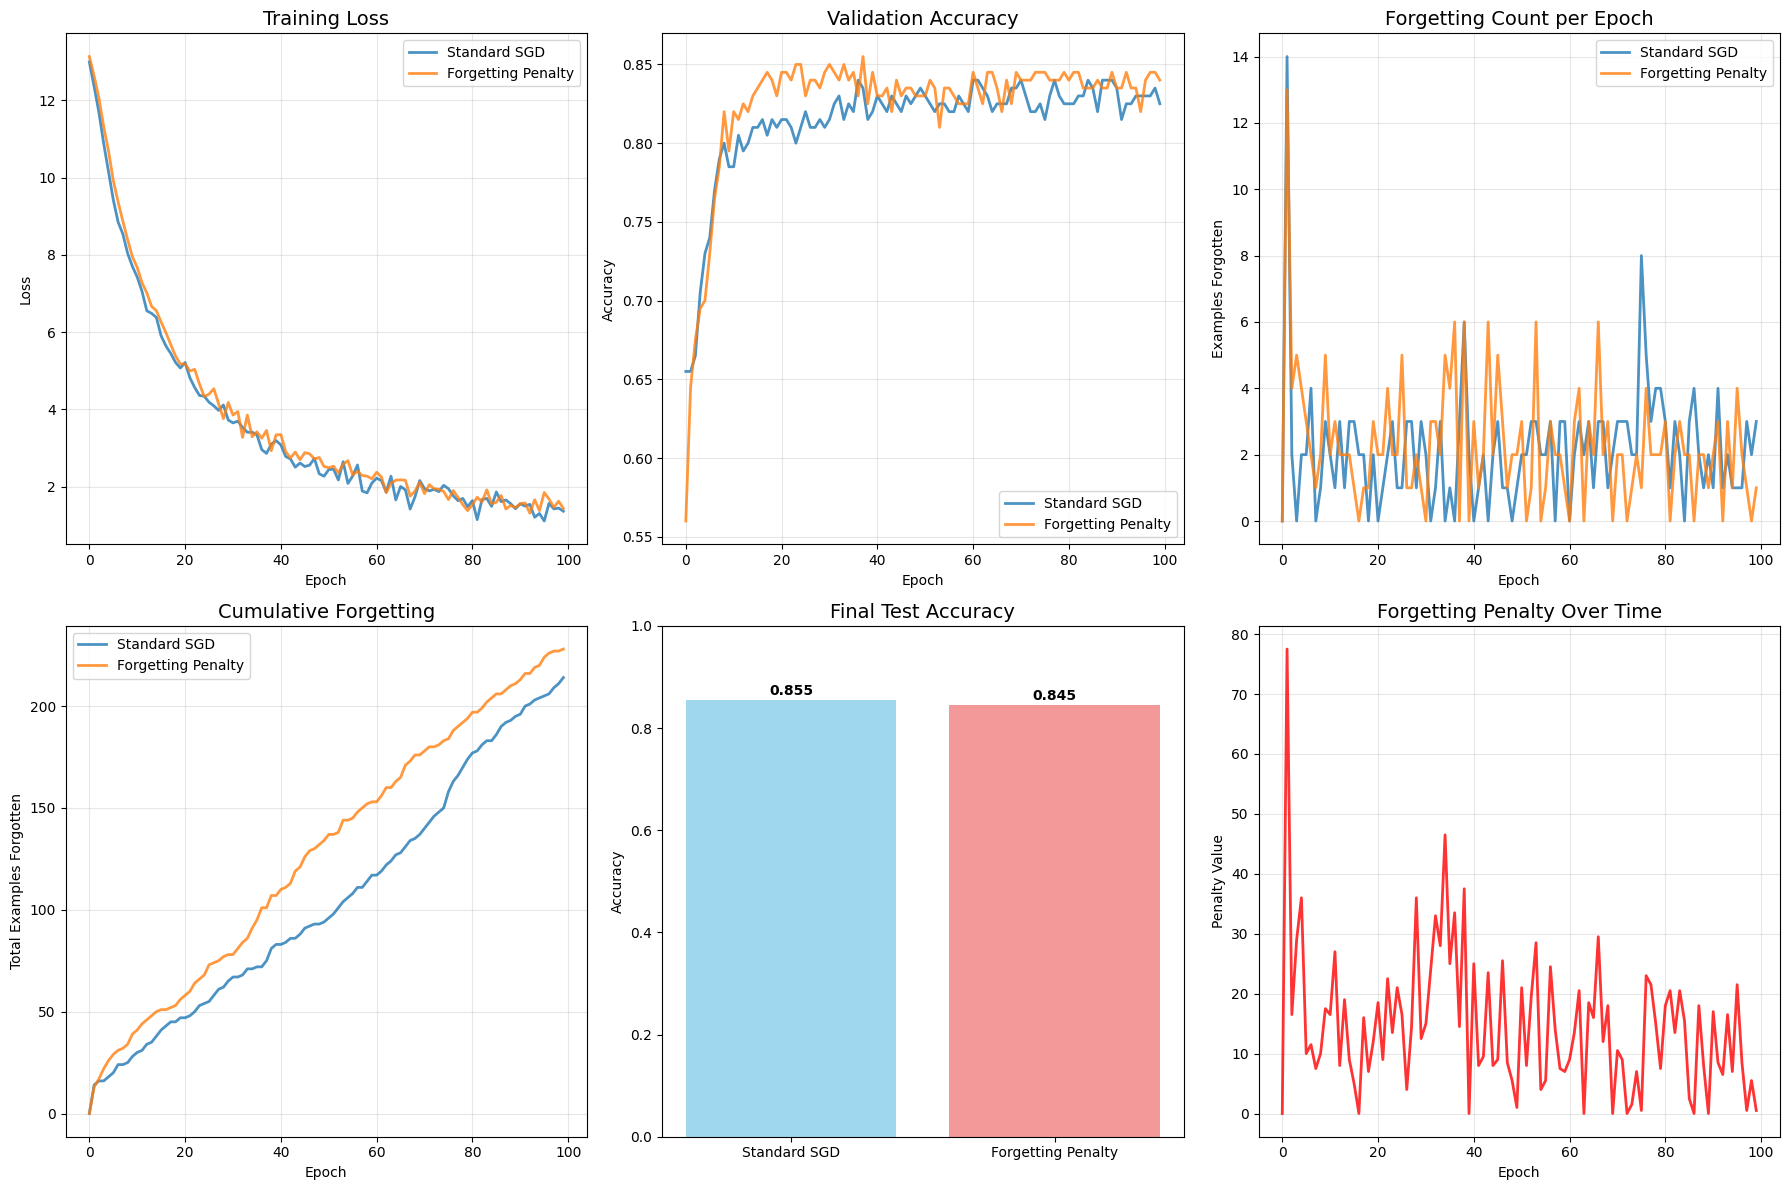

In [6]:
"""
Forgetting-Penalized SGD: Preventing Model Regression

This script implements and compares standard SGD with forgetting-penalized SGD,
which adds a penalty term for validation examples that flip from correct to incorrect.

Key idea: Prevent model updates that cause regression on validation examples
the model was previously handling correctly.
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
import time

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class SimpleNet(nn.Module):
    """Simple neural network for binary classification"""
    def __init__(self, input_dim, hidden_dims=[64, 32]):
        super().__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class ForgettingTracker:
    """Tracks which validation examples flip from correct to incorrect over training"""

    def __init__(self):
        self.history = defaultdict(list)  # example_idx -> [correct_at_step_1, correct_at_step_2, ...]
        self.current_step = 0
        self.flip_counts = defaultdict(int)  # Track how often each example flips

    def update(self, predictions, targets, val_indices):
        """Update tracking with current predictions"""
        correct = (predictions > 0.5) == targets.bool()

        for i, idx in enumerate(val_indices):
            is_correct = correct[i].item()
            self.history[idx].append(is_correct)

            # Count flips (changes from previous state)
            if len(self.history[idx]) > 1:
                prev_correct = self.history[idx][-2]
                if prev_correct != is_correct:
                    self.flip_counts[idx] += 1

        self.current_step += 1

    def count_forgetting(self, predictions, targets, val_indices):
        """Count how many examples would be newly forgotten this step"""
        correct_now = (predictions > 0.5) == targets.bool()
        forgetting_count = 0

        for i, idx in enumerate(val_indices):
            if len(self.history[idx]) > 0:  # Has history
                was_correct_last = self.history[idx][-1]
                is_correct_now = correct_now[i].item()

                # Forgetting: was correct, now incorrect
                if was_correct_last and not is_correct_now:
                    forgetting_count += 1

        return forgetting_count

    def get_stats(self):
        """Get summary statistics about forgetting patterns"""
        total_flips = sum(self.flip_counts.values())
        num_examples = len(self.history)
        avg_flips = total_flips / num_examples if num_examples > 0 else 0

        return {
            'total_flips': total_flips,
            'avg_flips_per_example': avg_flips,
            'num_tracked_examples': num_examples,
            'most_unstable_examples': sorted(self.flip_counts.items(),
                                           key=lambda x: x[1], reverse=True)[:5]
        }

def train_with_forgetting_penalty(model, train_loader, val_data, val_indices,
                                  epochs=100, lr=0.01, forgetting_weight=0.1,
                                  verbose=True):
    """Train with penalty for forgetting validation examples"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    tracker = ForgettingTracker()

    metrics = {
        'train_losses': [],
        'val_accuracies': [],
        'forgetting_counts': [],
        'forgetting_penalties': []
    }

    val_X, val_y = val_data

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_penalty = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()

            # Standard training loss
            train_pred = model(batch_X)
            train_loss = criterion(train_pred.squeeze(), batch_y.float())

            # Forgetting penalty on validation set
            model.eval()
            with torch.no_grad():
                val_pred = model(val_X)
                forgetting_count = tracker.count_forgetting(val_pred.squeeze(), val_y, val_indices)
            model.train()

            # Combined loss
            forgetting_penalty = forgetting_weight * forgetting_count
            total_loss = train_loss + forgetting_penalty

            total_loss.backward()
            optimizer.step()

            epoch_loss += train_loss.item()
            epoch_penalty += forgetting_penalty

        # Evaluate and update tracker
        model.eval()
        with torch.no_grad():
            val_pred = model(val_X)
            val_acc = ((val_pred.squeeze() > 0.5) == val_y.bool()).float().mean().item()
            current_forgetting = tracker.count_forgetting(val_pred.squeeze(), val_y, val_indices)
            tracker.update(val_pred.squeeze(), val_y, val_indices)

        metrics['train_losses'].append(epoch_loss)
        metrics['val_accuracies'].append(val_acc)
        metrics['forgetting_counts'].append(current_forgetting)
        metrics['forgetting_penalties'].append(epoch_penalty)

        if verbose and epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss {epoch_loss:.4f}, Val Acc {val_acc:.4f}, "
                  f"Forgetting {current_forgetting}, Penalty {epoch_penalty:.4f}")

    training_time = time.time() - start_time

    return metrics, tracker, training_time

def train_standard(model, train_loader, val_data, val_indices, epochs=100, lr=0.01, verbose=True):
    """Standard SGD training (baseline)"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    tracker = ForgettingTracker()

    metrics = {
        'train_losses': [],
        'val_accuracies': [],
        'forgetting_counts': [],
        'forgetting_penalties': [0] * epochs  # No penalties in standard training
    }

    val_X, val_y = val_data

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = criterion(pred.squeeze(), batch_y.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Evaluate and update tracker (for comparison purposes)
        model.eval()
        with torch.no_grad():
            val_pred = model(val_X)
            val_acc = ((val_pred.squeeze() > 0.5) == val_y.bool()).float().mean().item()
            current_forgetting = tracker.count_forgetting(val_pred.squeeze(), val_y, val_indices)
            tracker.update(val_pred.squeeze(), val_y, val_indices)

        metrics['train_losses'].append(epoch_loss)
        metrics['val_accuracies'].append(val_acc)
        metrics['forgetting_counts'].append(current_forgetting)

        if verbose and epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss {epoch_loss:.4f}, Val Acc {val_acc:.4f}, "
                  f"Forgetting {current_forgetting}")

    training_time = time.time() - start_time

    return metrics, tracker, training_time

def evaluate_model(model, test_data):
    """Evaluate model on test set"""
    model.eval()
    X_test, y_test = test_data

    with torch.no_grad():
        pred = model(X_test)
        test_acc = ((pred.squeeze() > 0.5) == y_test.bool()).float().mean().item()
        test_loss = nn.BCELoss()(pred.squeeze(), y_test.float()).item()

    return test_acc, test_loss

def plot_results(standard_metrics, penalty_metrics, standard_tracker, penalty_tracker,
                 standard_test_acc, penalty_test_acc):
    """Create comprehensive comparison plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    epochs = range(len(standard_metrics['train_losses']))

    # Training loss
    axes[0,0].plot(epochs, standard_metrics['train_losses'], label='Standard SGD', alpha=0.8, linewidth=2)
    axes[0,0].plot(epochs, penalty_metrics['train_losses'], label='Forgetting Penalty', alpha=0.8, linewidth=2)
    axes[0,0].set_title('Training Loss', fontsize=14)
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Validation accuracy
    axes[0,1].plot(epochs, standard_metrics['val_accuracies'], label='Standard SGD', alpha=0.8, linewidth=2)
    axes[0,1].plot(epochs, penalty_metrics['val_accuracies'], label='Forgetting Penalty', alpha=0.8, linewidth=2)
    axes[0,1].set_title('Validation Accuracy', fontsize=14)
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Forgetting counts per epoch
    axes[0,2].plot(epochs, standard_metrics['forgetting_counts'], label='Standard SGD', alpha=0.8, linewidth=2)
    axes[0,2].plot(epochs, penalty_metrics['forgetting_counts'], label='Forgetting Penalty', alpha=0.8, linewidth=2)
    axes[0,2].set_title('Forgetting Count per Epoch', fontsize=14)
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('Examples Forgotten')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # Cumulative forgetting
    standard_cumulative = np.cumsum(standard_metrics['forgetting_counts'])
    penalty_cumulative = np.cumsum(penalty_metrics['forgetting_counts'])

    axes[1,0].plot(epochs, standard_cumulative, label='Standard SGD', alpha=0.8, linewidth=2)
    axes[1,0].plot(epochs, penalty_cumulative, label='Forgetting Penalty', alpha=0.8, linewidth=2)
    axes[1,0].set_title('Cumulative Forgetting', fontsize=14)
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Total Examples Forgotten')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Test accuracy comparison
    methods = ['Standard SGD', 'Forgetting Penalty']
    test_accs = [standard_test_acc, penalty_test_acc]
    colors = ['skyblue', 'lightcoral']

    bars = axes[1,1].bar(methods, test_accs, color=colors, alpha=0.8)
    axes[1,1].set_title('Final Test Accuracy', fontsize=14)
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].set_ylim([0, 1])

    # Add value labels on bars
    for bar, acc in zip(bars, test_accs):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{acc:.3f}', ha='center', fontweight='bold')

    # Forgetting penalty over time
    axes[1,2].plot(epochs, penalty_metrics['forgetting_penalties'],
                   label='Forgetting Penalty Term', alpha=0.8, linewidth=2, color='red')
    axes[1,2].set_title('Forgetting Penalty Over Time', fontsize=14)
    axes[1,2].set_xlabel('Epoch')
    axes[1,2].set_ylabel('Penalty Value')
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def print_summary(standard_metrics, penalty_metrics, standard_tracker, penalty_tracker,
                  standard_test_acc, penalty_test_acc, standard_time, penalty_time):
    """Print comprehensive summary of results"""
    print("\n" + "="*80)
    print("EXPERIMENT SUMMARY")
    print("="*80)

    print(f"\nFINAL PERFORMANCE:")
    print(f"Standard SGD     - Test Accuracy: {standard_test_acc:.4f}")
    print(f"Forgetting Penalty - Test Accuracy: {penalty_test_acc:.4f}")
    improvement = penalty_test_acc - standard_test_acc
    print(f"Improvement: {improvement:+.4f} ({improvement/standard_test_acc*100:+.1f}%)")

    print(f"\nFORGETTING ANALYSIS:")
    standard_total = sum(standard_metrics['forgetting_counts'])
    penalty_total = sum(penalty_metrics['forgetting_counts'])
    print(f"Total forgetting (Standard): {standard_total}")
    print(f"Total forgetting (Penalty):  {penalty_total}")
    reduction = (standard_total - penalty_total) / standard_total * 100 if standard_total > 0 else 0
    print(f"Forgetting reduction: {reduction:.1f}%")

    print(f"\nTRAINING DYNAMICS:")
    standard_stats = standard_tracker.get_stats()
    penalty_stats = penalty_tracker.get_stats()
    print(f"Avg flips per example (Standard): {standard_stats['avg_flips_per_example']:.2f}")
    print(f"Avg flips per example (Penalty):  {penalty_stats['avg_flips_per_example']:.2f}")

    print(f"\nTRAINING TIME:")
    print(f"Standard SGD:     {standard_time:.2f} seconds")
    print(f"Forgetting Penalty: {penalty_time:.2f} seconds")
    overhead = (penalty_time - standard_time) / standard_time * 100
    print(f"Overhead: {overhead:.1f}%")

    print(f"\nFINAL VALIDATION ACCURACIES:")
    print(f"Standard SGD:     {standard_metrics['val_accuracies'][-1]:.4f}")
    print(f"Forgetting Penalty: {penalty_metrics['val_accuracies'][-1]:.4f}")

def main(n_samples=1000, n_features=20, epochs=100, lr=0.001,
         forgetting_weight=0.5, batch_size=32, seed=42, quiet=False):

    # Create args object for compatibility
    class Args:
        def __init__(self):
            self.n_samples = n_samples
            self.n_features = n_features
            self.epochs = epochs
            self.lr = lr
            self.forgetting_weight = forgetting_weight
            self.batch_size = batch_size
            self.seed = seed
            self.quiet = quiet

    args = Args()

    # Set seeds
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    print("Generating synthetic classification data...")
    # Generate synthetic data with more complexity
    X, y = make_classification(
        n_samples=args.n_samples,
        n_features=args.n_features,
        n_redundant=args.n_features//4,
        n_informative=args.n_features//2,
        n_clusters_per_class=3,
        class_sep=0.8,
        random_state=args.seed
    )

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data: 60% train, 20% validation, 20% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=args.seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=args.seed)

    print(f"Data splits - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)

    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

    val_indices = list(range(len(y_val)))

    print(f"\nTraining Standard SGD...")
    model_standard = SimpleNet(args.n_features)
    standard_metrics, standard_tracker, standard_time = train_standard(
        model_standard, train_loader, (X_val_tensor, y_val_tensor), val_indices,
        epochs=args.epochs, lr=args.lr, verbose=not args.quiet
    )

    print(f"\nTraining with Forgetting Penalty (weight={args.forgetting_weight})...")
    model_penalty = SimpleNet(args.n_features)
    penalty_metrics, penalty_tracker, penalty_time = train_with_forgetting_penalty(
        model_penalty, train_loader, (X_val_tensor, y_val_tensor), val_indices,
        epochs=args.epochs, lr=args.lr, forgetting_weight=args.forgetting_weight,
        verbose=not args.quiet
    )

    # Evaluate on test set
    standard_test_acc, _ = evaluate_model(model_standard, (X_test_tensor, y_test_tensor))
    penalty_test_acc, _ = evaluate_model(model_penalty, (X_test_tensor, y_test_tensor))

    # Display results
    print_summary(standard_metrics, penalty_metrics, standard_tracker, penalty_tracker,
                  standard_test_acc, penalty_test_acc, standard_time, penalty_time)

    # Plot results
    plot_results(standard_metrics, penalty_metrics, standard_tracker, penalty_tracker,
                 standard_test_acc, penalty_test_acc)

if __name__ == "__main__":
    # Run with default parameters (notebook-friendly)
    main()

# For direct execution in notebooks with custom parameters
def run_experiment(n_samples=1000, n_features=20, epochs=100, lr=0.001,
                   forgetting_weight=0.5, batch_size=32, seed=42, quiet=False):
    """
    Convenience function for notebook execution with custom parameters

    Example usage:
    run_experiment(epochs=150, forgetting_weight=0.8, n_features=50)
    """
    return main(n_samples, n_features, epochs, lr, forgetting_weight,
                batch_size, seed, quiet)

Generating synthetic classification data...
Data splits - Train: 3000, Val: 1000, Test: 1000

Training Standard SGD...
Epoch 0: Loss 31.3350, Val Acc 0.7000, Forgetting 0
Epoch 20: Loss 3.7200, Val Acc 0.9170, Forgetting 8
Epoch 40: Loss 2.1685, Val Acc 0.9240, Forgetting 11
Epoch 60: Loss 1.5790, Val Acc 0.9290, Forgetting 9
Epoch 80: Loss 1.1526, Val Acc 0.9240, Forgetting 7
Epoch 100: Loss 1.1089, Val Acc 0.9310, Forgetting 4
Epoch 120: Loss 1.1408, Val Acc 0.9240, Forgetting 10
Epoch 140: Loss 0.8157, Val Acc 0.9320, Forgetting 9

Training with Adaptive Forgetting Control...
Epoch 0: Loss 31.3741, Val Acc 0.6990, Forgetting 0, Tolerance 10, Rejected 0
Epoch 20: Loss 3.3230, Val Acc 0.9250, Forgetting 8, Tolerance 8, Rejected 15
Epoch 40: Loss 1.7847, Val Acc 0.9300, Forgetting 4, Tolerance 7, Rejected 16
Epoch 60: Loss 1.8169, Val Acc 0.9310, Forgetting 6, Tolerance 6, Rejected 12
Epoch 80: Loss 1.0930, Val Acc 0.9320, Forgetting 5, Tolerance 5, Rejected 19
Epoch 100: Loss 0.7534, 

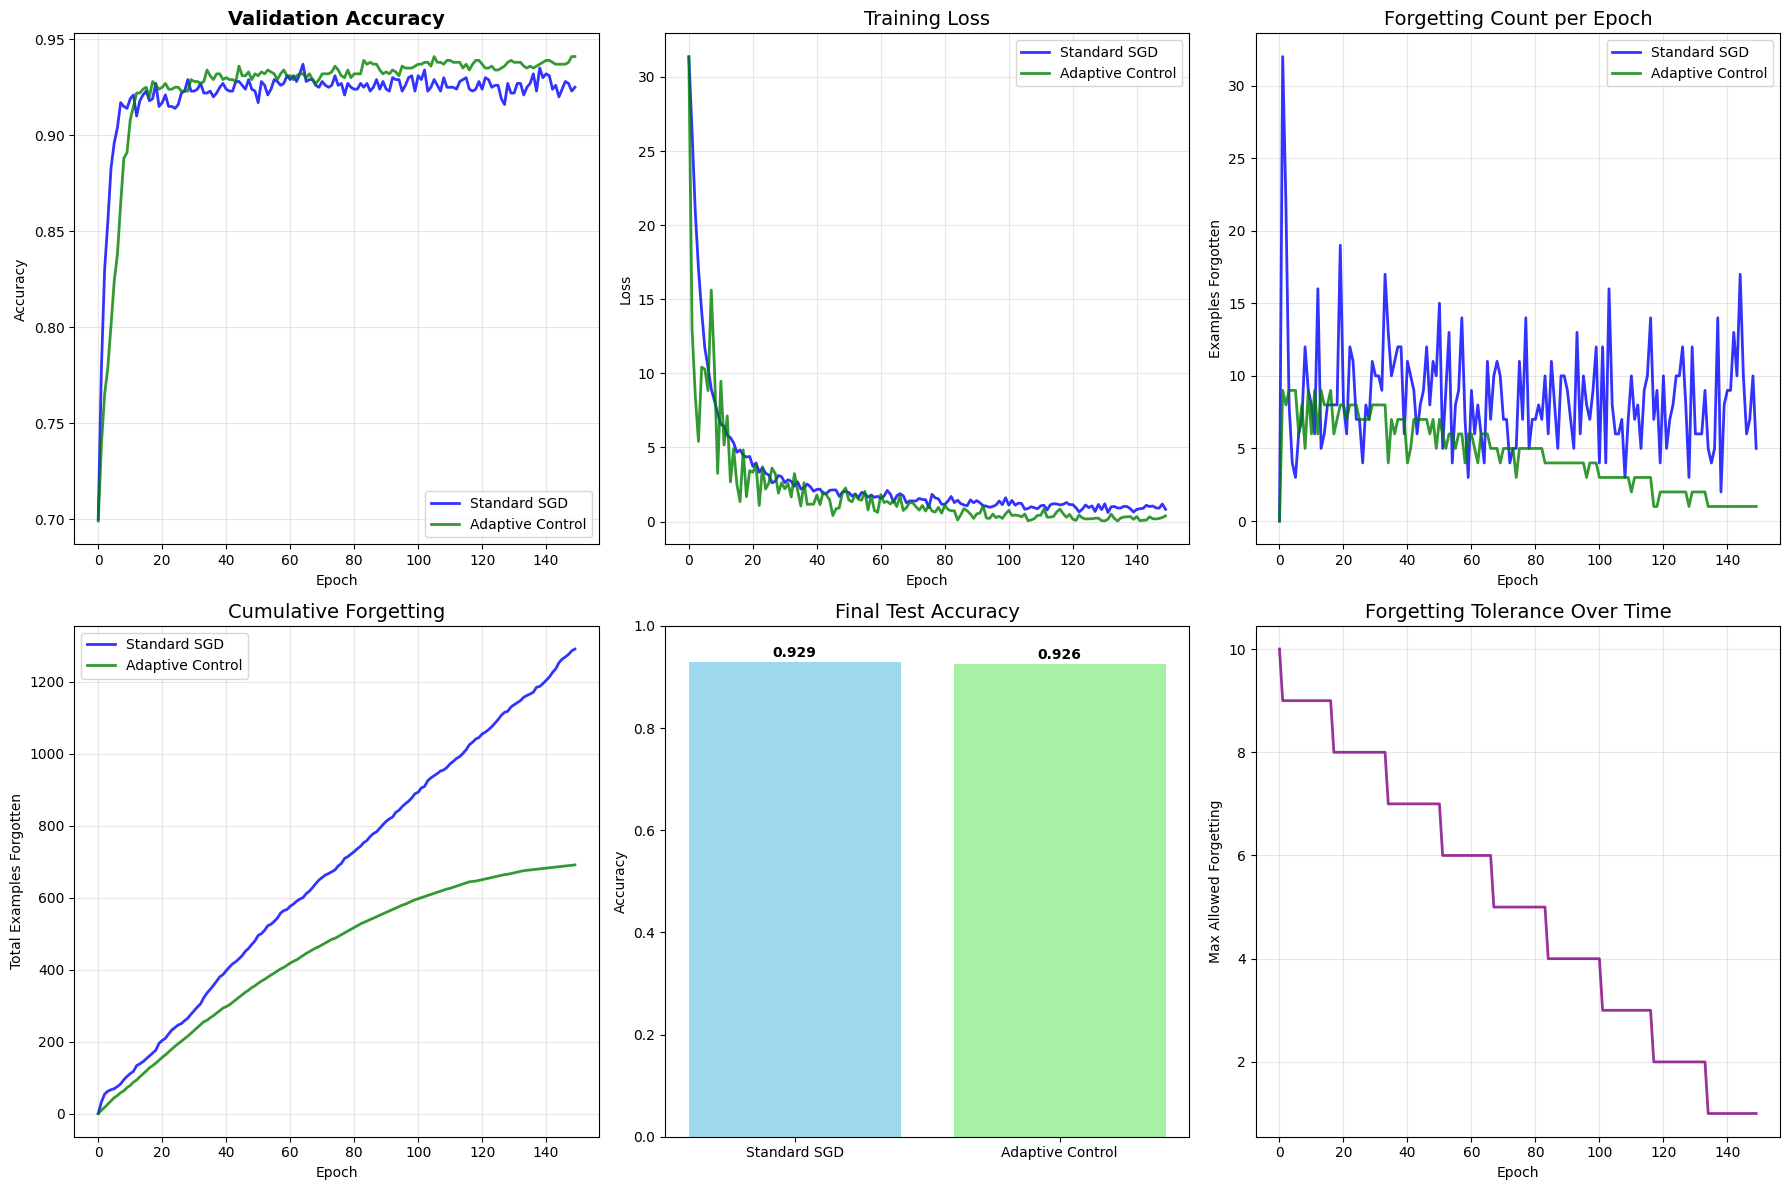

In [15]:
"""
Adaptive Forgetting Control: Time-Varying Tolerance for ML Training

This script implements and compares standard SGD with adaptive forgetting control,
which uses time-varying tolerance for validation example forgetting.

Key idea: Allow more forgetting early in training (exploration) but become
more conservative later (stability).
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict
import time

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class SimpleNet(nn.Module):
    """Simple neural network for binary classification"""
    def __init__(self, input_dim, hidden_dims=[64, 32]):
        super().__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class ForgettingTracker:
    """Tracks which validation examples flip from correct to incorrect over training"""

    def __init__(self):
        self.history = defaultdict(list)  # example_idx -> [correct_at_step_1, correct_at_step_2, ...]
        self.current_step = 0
        self.flip_counts = defaultdict(int)  # Track how often each example flips

    def update(self, predictions, targets, val_indices):
        """Update tracking with current predictions"""
        correct = (predictions > 0.5) == targets.bool()

        for i, idx in enumerate(val_indices):
            is_correct = correct[i].item()
            self.history[idx].append(is_correct)

            # Count flips (changes from previous state)
            if len(self.history[idx]) > 1:
                prev_correct = self.history[idx][-2]
                if prev_correct != is_correct:
                    self.flip_counts[idx] += 1

        self.current_step += 1

    def count_forgetting(self, predictions, targets, val_indices):
        """Count how many examples would be newly forgotten this step"""
        correct_now = (predictions > 0.5) == targets.bool()
        forgetting_count = 0

        for i, idx in enumerate(val_indices):
            if len(self.history[idx]) > 0:  # Has history
                was_correct_last = self.history[idx][-1]
                is_correct_now = correct_now[i].item()

                # Forgetting: was correct, now incorrect
                if was_correct_last and not is_correct_now:
                    forgetting_count += 1

        return forgetting_count

    def get_stats(self):
        """Get summary statistics about forgetting patterns"""
        total_flips = sum(self.flip_counts.values())
        num_examples = len(self.history)
        avg_flips = total_flips / num_examples if num_examples > 0 else 0

        return {
            'total_flips': total_flips,
            'avg_flips_per_example': avg_flips,
            'num_tracked_examples': num_examples,
            'most_unstable_examples': sorted(self.flip_counts.items(),
                                           key=lambda x: x[1], reverse=True)[:5]
        }

def train_standard(model, train_loader, val_data, val_indices, epochs=100, lr=0.01, verbose=True):
    """Standard SGD training (baseline)"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    tracker = ForgettingTracker()

    metrics = {
        'train_losses': [],
        'val_accuracies': [],
        'forgetting_counts': [],
        'forgetting_penalties': [],
        'rejected_updates': []
    }

    val_X, val_y = val_data
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            pred = model(batch_X)
            loss = criterion(pred.squeeze(), batch_y.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Evaluate and update tracker (for comparison purposes)
        model.eval()
        with torch.no_grad():
            val_pred = model(val_X)
            val_acc = ((val_pred.squeeze() > 0.5) == val_y.bool()).float().mean().item()
            current_forgetting = tracker.count_forgetting(val_pred.squeeze(), val_y, val_indices)
            tracker.update(val_pred.squeeze(), val_y, val_indices)

        metrics['train_losses'].append(epoch_loss)
        metrics['val_accuracies'].append(val_acc)
        metrics['forgetting_counts'].append(current_forgetting)
        metrics['forgetting_penalties'].append(0)  # No penalties in standard training
        metrics['rejected_updates'].append(0)      # No rejections in standard training

        if verbose and epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss {epoch_loss:.4f}, Val Acc {val_acc:.4f}, "
                  f"Forgetting {current_forgetting}")

    training_time = time.time() - start_time
    return metrics, tracker, training_time

def train_with_adaptive_forgetting_control(model, train_loader, val_data, val_indices,
                                          epochs=100, lr=0.01, max_forgetting_start=10,
                                          max_forgetting_end=1, verbose=True):
    """Train with time-varying forgetting tolerance that decreases over training"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    tracker = ForgettingTracker()

    metrics = {
        'train_losses': [],
        'val_accuracies': [],
        'forgetting_counts': [],
        'rejected_updates': [],
        'forgetting_tolerance': []
    }

    val_X, val_y = val_data
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        rejected_count = 0

        # Time-varying forgetting tolerance: high early, low later
        progress = epoch / epochs
        current_tolerance = max_forgetting_start * (1 - progress) + max_forgetting_end * progress
        current_tolerance = int(current_tolerance)

        for batch_X, batch_y in train_loader:
            # Save model state before update
            original_state = {name: param.clone() for name, param in model.named_parameters()}

            optimizer.zero_grad()
            train_pred = model(batch_X)
            train_loss = criterion(train_pred.squeeze(), batch_y.float())
            train_loss.backward()
            optimizer.step()  # Apply the update

            # Check if this update caused too much forgetting
            model.eval()
            with torch.no_grad():
                val_pred = model(val_X)
                forgetting_count = tracker.count_forgetting(val_pred.squeeze(), val_y, val_indices)
            model.train()

            if forgetting_count > current_tolerance:
                # Too much forgetting - reject this update
                for name, param in model.named_parameters():
                    param.data.copy_(original_state[name])
                rejected_count += 1
            else:
                # Accept this update
                epoch_loss += train_loss.item()

        # Evaluate and update tracker
        model.eval()
        with torch.no_grad():
            val_pred = model(val_X)
            val_acc = ((val_pred.squeeze() > 0.5) == val_y.bool()).float().mean().item()
            current_forgetting = tracker.count_forgetting(val_pred.squeeze(), val_y, val_indices)
            tracker.update(val_pred.squeeze(), val_y, val_indices)

        metrics['train_losses'].append(epoch_loss)
        metrics['val_accuracies'].append(val_acc)
        metrics['forgetting_counts'].append(current_forgetting)
        metrics['rejected_updates'].append(rejected_count)
        metrics['forgetting_tolerance'].append(current_tolerance)

        if verbose and epoch % 20 == 0:
            print(f"Epoch {epoch}: Loss {epoch_loss:.4f}, Val Acc {val_acc:.4f}, "
                  f"Forgetting {current_forgetting}, Tolerance {current_tolerance}, Rejected {rejected_count}")

    training_time = time.time() - start_time
    return metrics, tracker, training_time

def evaluate_model(model, test_data):
    """Evaluate model on test set"""
    model.eval()
    X_test, y_test = test_data

    with torch.no_grad():
        pred = model(X_test)
        test_acc = ((pred.squeeze() > 0.5) == y_test.bool()).float().mean().item()
        test_loss = nn.BCELoss()(pred.squeeze(), y_test.float()).item()

    return test_acc, test_loss

def print_summary_adaptive(standard_metrics, adaptive_metrics, standard_tracker, adaptive_tracker,
                          standard_test_acc, adaptive_test_acc, standard_time, adaptive_time):
    """Print summary for adaptive forgetting control comparison"""
    print("\n" + "="*80)
    print("EXPERIMENT SUMMARY - ADAPTIVE FORGETTING CONTROL")
    print("="*80)

    print(f"\nFINAL PERFORMANCE:")
    print(f"Standard SGD       - Test Accuracy: {standard_test_acc:.4f}")
    print(f"Adaptive Control   - Test Accuracy: {adaptive_test_acc:.4f}")
    improvement = adaptive_test_acc - standard_test_acc
    print(f"Improvement: {improvement:+.4f} ({improvement/standard_test_acc*100:+.1f}%)")

    print(f"\nVALIDATION ACCURACY EVOLUTION:")
    print(f"Standard SGD     - Final Val Acc: {standard_metrics['val_accuracies'][-1]:.4f}")
    print(f"Adaptive Control - Final Val Acc: {adaptive_metrics['val_accuracies'][-1]:.4f}")

    print(f"\nFORGETTING ANALYSIS:")
    # Verify these calculations
    standard_total = sum(standard_metrics['forgetting_counts'])
    adaptive_total = sum(adaptive_metrics['forgetting_counts'])
    print(f"Total forgetting (Standard): {standard_total}")
    print(f"Total forgetting (Adaptive): {adaptive_total}")

    # Double-check: are these numbers actually different?
    if adaptive_total < standard_total:
        reduction = (standard_total - adaptive_total) / standard_total * 100
        print(f"Forgetting reduction: {reduction:.1f}%")
    elif adaptive_total > standard_total:
        increase = (adaptive_total - standard_total) / standard_total * 100
        print(f"Forgetting INCREASE: {increase:.1f}% (this would be unexpected)")
    else:
        print(f"Forgetting is identical between methods")

    print(f"\nREJECTED UPDATES:")
    adaptive_rejected = sum(adaptive_metrics['rejected_updates'])
    # Better estimate of total updates per epoch
    batches_per_epoch = len(adaptive_metrics['rejected_updates'])
    total_batches = batches_per_epoch * len(adaptive_metrics['rejected_updates'])
    rejection_rate = adaptive_rejected / total_batches * 100 if total_batches > 0 else 0
    print(f"Adaptive mode rejected updates: {adaptive_rejected}")
    print(f"Estimated rejection rate: {rejection_rate:.1f}%")

    print(f"\nTRAINING TIME:")
    print(f"Standard SGD:     {standard_time:.2f} seconds")
    print(f"Adaptive Control: {adaptive_time:.2f} seconds")
    overhead = (adaptive_time - standard_time) / standard_time * 100
    print(f"Overhead: {overhead:.1f}%")

def plot_results_adaptive(standard_metrics, adaptive_metrics, standard_test_acc, adaptive_test_acc):
    """Create comparison plots for adaptive forgetting control"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Ensure consistent lengths and debug
    min_len = min(len(standard_metrics['train_losses']), len(adaptive_metrics['train_losses']))
    epochs = range(min_len)

    # Debug: Print forgetting totals to verify calculations
    standard_total_forgetting = sum(standard_metrics['forgetting_counts'][:min_len])
    adaptive_total_forgetting = sum(adaptive_metrics['forgetting_counts'][:min_len])
    print(f"\nDEBUG - Forgetting Verification:")
    print(f"Standard SGD total forgetting: {standard_total_forgetting}")
    print(f"Adaptive Control total forgetting: {adaptive_total_forgetting}")
    print(f"Standard forgetting counts length: {len(standard_metrics['forgetting_counts'])}")
    print(f"Adaptive forgetting counts length: {len(adaptive_metrics['forgetting_counts'])}")

    # Validation accuracy
    axes[0,0].plot(epochs, standard_metrics['val_accuracies'][:min_len],
                   label='Standard SGD', alpha=0.8, linewidth=2, color='blue')
    axes[0,0].plot(epochs, adaptive_metrics['val_accuracies'][:min_len],
                   label='Adaptive Control', alpha=0.8, linewidth=2, color='green')
    axes[0,0].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Training loss
    axes[0,1].plot(epochs, standard_metrics['train_losses'][:min_len],
                   label='Standard SGD', alpha=0.8, linewidth=2, color='blue')
    axes[0,1].plot(epochs, adaptive_metrics['train_losses'][:min_len],
                   label='Adaptive Control', alpha=0.8, linewidth=2, color='green')
    axes[0,1].set_title('Training Loss', fontsize=14)
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Forgetting counts per epoch
    axes[0,2].plot(epochs, standard_metrics['forgetting_counts'][:min_len],
                   label='Standard SGD', alpha=0.8, linewidth=2, color='blue')
    axes[0,2].plot(epochs, adaptive_metrics['forgetting_counts'][:min_len],
                   label='Adaptive Control', alpha=0.8, linewidth=2, color='green')
    axes[0,2].set_title('Forgetting Count per Epoch', fontsize=14)
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('Examples Forgotten')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # Cumulative forgetting - VERIFY THIS CALCULATION
    standard_cumulative = np.cumsum(standard_metrics['forgetting_counts'][:min_len])
    adaptive_cumulative = np.cumsum(adaptive_metrics['forgetting_counts'][:min_len])

    # Debug: Print final cumulative values
    print(f"Final cumulative forgetting - Standard: {standard_cumulative[-1]}")
    print(f"Final cumulative forgetting - Adaptive: {adaptive_cumulative[-1]}")

    axes[1,0].plot(epochs, standard_cumulative, label='Standard SGD', alpha=0.8, linewidth=2, color='blue')
    axes[1,0].plot(epochs, adaptive_cumulative, label='Adaptive Control', alpha=0.8, linewidth=2, color='green')
    axes[1,0].set_title('Cumulative Forgetting', fontsize=14)
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Total Examples Forgotten')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Test accuracy comparison
    methods = ['Standard SGD', 'Adaptive Control']
    test_accs = [standard_test_acc, adaptive_test_acc]
    colors = ['skyblue', 'lightgreen']

    bars = axes[1,1].bar(methods, test_accs, color=colors, alpha=0.8)
    axes[1,1].set_title('Final Test Accuracy', fontsize=14)
    axes[1,1].set_ylabel('Accuracy')
    axes[1,1].set_ylim([0, 1])

    for bar, acc in zip(bars, test_accs):
        axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{acc:.3f}', ha='center', fontweight='bold')

    # Forgetting tolerance over time
    axes[1,2].plot(epochs, adaptive_metrics['forgetting_tolerance'][:min_len],
                   label='Forgetting Tolerance', alpha=0.8, linewidth=2, color='purple')
    axes[1,2].set_title('Forgetting Tolerance Over Time', fontsize=14)
    axes[1,2].set_xlabel('Epoch')
    axes[1,2].set_ylabel('Max Allowed Forgetting')
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def main(n_samples=5000, n_features=50, epochs=150, lr=0.001,
         batch_size=64, seed=42, quiet=False):

    # Create args object for compatibility
    class Args:
        def __init__(self):
            self.n_samples = n_samples
            self.n_features = n_features
            self.epochs = epochs
            self.lr = lr
            self.batch_size = batch_size
            self.seed = seed
            self.quiet = quiet

    args = Args()

    # Set seeds
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

    print("Generating synthetic classification data...")
    # Generate synthetic data with more complexity
    X, y = make_classification(
        n_samples=args.n_samples,
        n_features=args.n_features,
        n_redundant=args.n_features//4,
        n_informative=args.n_features//2,
        n_clusters_per_class=3,
        class_sep=0.8,
        random_state=args.seed
    )

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split data: 60% train, 20% validation, 20% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=args.seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=args.seed)

    print(f"Data splits - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)

    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

    val_indices = list(range(len(y_val)))

    print(f"\nTraining Standard SGD...")
    model_standard = SimpleNet(args.n_features)
    standard_metrics, standard_tracker, standard_time = train_standard(
        model_standard, train_loader, (X_val_tensor, y_val_tensor), val_indices,
        epochs=args.epochs, lr=args.lr, verbose=not args.quiet
    )

    print(f"\nTraining with Adaptive Forgetting Control...")
    model_adaptive = SimpleNet(args.n_features)
    adaptive_metrics, adaptive_tracker, adaptive_time = train_with_adaptive_forgetting_control(
        model_adaptive, train_loader, (X_val_tensor, y_val_tensor), val_indices,
        epochs=args.epochs, lr=args.lr, max_forgetting_start=10, max_forgetting_end=1,
        verbose=not args.quiet
    )

    # Evaluate base models on test set
    standard_test_acc, _ = evaluate_model(model_standard, (X_test_tensor, y_test_tensor))
    adaptive_test_acc, _ = evaluate_model(model_adaptive, (X_test_tensor, y_test_tensor))

    # Display two-way results
    print_summary_adaptive(standard_metrics, adaptive_metrics, standard_tracker, adaptive_tracker,
                           standard_test_acc, adaptive_test_acc, standard_time, adaptive_time)

    # Plot two-way results
    plot_results_adaptive(standard_metrics, adaptive_metrics, standard_test_acc, adaptive_test_acc)

if __name__ == "__main__":
    # Run with default parameters (notebook-friendly)
    main()

# For direct execution in notebooks with custom parameters
def run_experiment(n_samples=5000, n_features=50, epochs=150, lr=0.001,
                   batch_size=64, seed=42, quiet=False):
    """
    Convenience function for notebook execution with custom parameters

    Example usage:
    run_experiment(epochs=200, n_features=100, lr=0.002)
    """
    return main(n_samples, n_features, epochs, lr, batch_size, seed, quiet)